<a href="https://www.kaggle.com/code/raghavrastogi75/top-13-result-blending-is-the-key?scriptVersionId=91175721" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="toc_section"></a>
## Contents of this notebook

[**Raghav Rastogi**](https://www.kaggle.com/raghavrastogi75) 


* [Introduction](#1)
* [Data Import](#2)
* [Data Cleaning](#3)
* [Data Preprocessing and feature engineering](#4)
    - [Handling missing values and combining/reducing the features](#5)
    - [Finding the most important features in the dataset](#6)
* [Preparing the test and train dataset](#7)
* [Finding best hyperparameters](#8)
    - [Lasso](#9)
    - [Ridge](#10)
    - [Elastic Net](#11)
    - [Gradient Boost Regression](#12)
    - [LightGBM](#13)
    - [XGBoost](#14)
* [Creating all models](#15)
* [Preprocessing of test set](#16)
* [Creating Blended Model](#17)
* [Prediction](#18)

# Introduction<span id="1"></span>

### Before I begin, I wish to inform that the data preprocessing on this notebook has been heavily referred from [this](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset) notebook by Juliencs. I am grateful to have learned so much from it. I have tried to take up his preprocessing techniques and create Blended models to minimise the error as much as possible. I will try to explain everything in as simple manner as possible.

## If you find this notebook helpful please **UPVOTE** and do share your thoughts on what other ways could this result be improved.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Starting with Data Inport<span id="2"></span>

In [2]:
sample = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


### Having a look at the columns

In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Having a look at the NULL values and type of data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning<span id="3"></span>

### Looking at outliers

Text(0.5, 1.0, 'Area vs price')

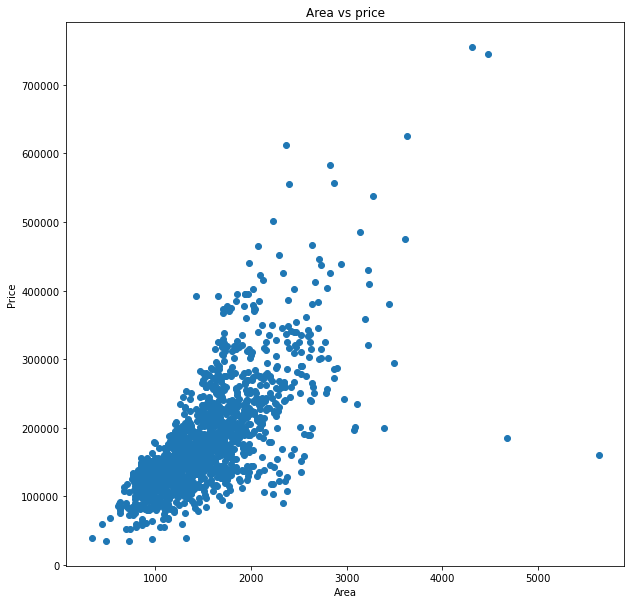

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
plt.scatter(train['GrLivArea'],train['SalePrice'])
plt.xlabel('Area')
plt.ylabel('Price')
plt.title("Area vs price")

As we can see that the bottom 2 points could be removed entirely as they vary non-linearly as compared to other data points

In [6]:
train = train.loc[(train['GrLivArea'] < 4000) | (train['SalePrice'] > 300000)]


### Transforming the target variable to log values so that the error is equally impactful to the low and high prices.

In [7]:
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train.SalePrice
# train.info()

# Data Preprocessing and feature engineering<span id="4"></span>

### Handling missing values and combining/reducing the features while still holding the information <span id="5"></span>

* Every explanation is below the code cell

In [8]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)


We are trying to remove every Null value with the best possible alternative. I made the initial mistake of generalising everything initially and trying to "Get Over" this step. But I realise now how important this is to improve the results.

In [9]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

Here we are removing the numerical data from the orignal categories and representing them in categorical data.

In [10]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Now we are trying to extract more useful information by converting categorical data to numerical by the degree of its quality. This makes the data highlt usable by reducing the dimensions which would have been otherwise created by One Hot Encoding.

In [11]:
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

There are two key steps performed here. First one being to reduce the number of categories by combinig the values to lesser number. This takes away some load on the model when we create the complete the data set after one hot encoding. The second one being to again combining the features itself that would contain the information of multiple columns in one omre concide format.

### Finding the most important features in the dataset <span id="6"></span>

In [12]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
#print(corr.SalePrice)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(corr.SalePrice)

Find most important features relative to target
SalePrice              1.000000
OverallQual            0.821405
AllSF                  0.820739
AllFlrsSF              0.735410
GrLivArea              0.725211
SimplOverallQual       0.706726
ExterQual              0.682226
GarageCars             0.681033
TotalBath              0.676678
KitchenQual            0.669990
GarageScore            0.657527
GarageArea             0.656129
TotalBsmtSF            0.647563
SimplExterQual         0.635358
SimplGarageScore       0.631468
1stFlrSF               0.620500
BsmtQual               0.616897
SimplKitchenQual       0.609207
OverallGrade           0.607983
FullBath               0.595899
SimplBsmtQual          0.592388
ExterGrade             0.588128
YearBuilt              0.587043
YearRemodAdd           0.565992
FireplaceQu            0.546791
GarageYrBlt            0.541638
TotRmsAbvGrd           0.537702
SimplOverallGrade      0.524971
FireplaceScore         0.523688
SimplKitchenScore      0

Now we can look at the most correlated attributes which will be an important factor while predicting the results.

In [13]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

Aim here is to create multiple features from highly correlated features which might help enhance the prediction. This could be taken from simple example which shows that squaring of the features makes data linearly separable. We can extrapolate this result to even power of 3.

In [14]:
cat_features = train.select_dtypes(include = ["object"]).columns
num_features = train.select_dtypes(exclude = ["object"]).columns
num_features = num_features.drop('SalePrice')
train_num = train[num_features]
train_cat = train[cat_features]


We now differentiate the categorical features and numerical features to perform the preprocessing accordingly.

In [15]:
print("before",train_num.isnull().values.sum())
train_num = train_num.fillna(train_num.median())
print("after",train_num.isnull().values.sum())

before 81
after 0


Handling remaining missing values by replacing it with median of the values.

In [16]:
from scipy.stats import skew

skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])
#print(skewed_features)


Transforming all the skewed values to log values to lessen the impact of outliers

In [17]:
train_cat = pd.get_dummies(train_cat)
print(train)

        Id MSSubClass MSZoning  LotFrontage  LotArea  Street Alley  LotShape  \
0        1       SC60       RL         65.0     8450       2  None         4   
1        2       SC20       RL         80.0     9600       2  None         4   
2        3       SC60       RL         68.0    11250       2  None         3   
3        4       SC70       RL         60.0     9550       2  None         3   
4        5       SC60       RL         84.0    14260       2  None         3   
...    ...        ...      ...          ...      ...     ...   ...       ...   
1455  1456       SC60       RL         62.0     7917       2  None         4   
1456  1457       SC20       RL         85.0    13175       2  None         4   
1457  1458       SC70       RL         66.0     9042       2  None         4   
1458  1459       SC20       RL         68.0     9717       2  None         4   
1459  1460       SC20       RL         75.0     9937       2  None         4   

     LandContour  Utilities  ... Garage

Applying one hot encoding to the categorical variables

# Preparing the test and train dataset <span id="7"></span>

In [18]:
from sklearn.model_selection import train_test_split

# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 42)


Applying Standard Scaler to the numerical dataset

In [19]:
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()
X_train.loc[:, num_features] = stdSc.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = stdSc.transform(X_test.loc[:, num_features])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Finding best hyperparameters<span id="8"></span>

## Our first goal is to create the models and find their best hyperparameters by running the model individually by gridsearch cross validation.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score

ridge = Ridge()

lasso = Lasso()

elasticnet = ElasticNet()

gbr = GradientBoostingRegressor()

lightgbm = LGBMRegressor()

xgboost = XGBRegressor()

scvr = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                           meta_regressor=xgboost,
                           use_features_in_secondary=True)

# Finding best parameters for each model
## I have marked them in comments as they take a lot of time to run and I have already found out the best parameters after running them multiple times

### Lasso<span id="9"></span>


In [21]:
# from sklearn.model_selection import GridSearchCV
# param_grid = [{'alpha': [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]}]
# grid_search = GridSearchCV(lasso, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
# grid_search.fit(X_train,y_train)
# print(grid_search.best_params_)
# np.sqrt(-grid_search.score(X_test,y_test))

### Ridge<span id="10"></span>

In [22]:
# param_grid = [{'alpha': [11.5,11.6,11.7,11.8,11.9,12,12.1,12.2,12.3]}]
# grid_search = GridSearchCV(ridge, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
# grid_search.fit(X_train,y_train)
# print(grid_search.best_params_)
# np.sqrt(-grid_search.score(X_test,y_test))

### Elasticnet<span id="11"></span>

In [23]:
# param_grid = [{'alpha': [0.001,0.0001,0.005]}]
# grid_search = GridSearchCV(elasticnet, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
# grid_search.fit(X_train,y_train)
# print(grid_search.best_params_)
# np.sqrt(-grid_search.score(X_test,y_test))

### Gradient Boost Regressor<span id="12"></span>

In [24]:
# param_grid = [{'n_estimators' : [3000,100], 'learning_rate':[0.05,0.1,0.005], 'max_depth':[1,4,8], 'max_features':['sqrt',320,80],
#               'min_samples_leaf':[15], 'min_samples_split':[10], 'loss':['huber']}]
# grid_search = GridSearchCV(gbr, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
# grid_search.fit(X_train,y_train)
# print(grid_search.best_params_)
# np.sqrt(-grid_search.score(X_test,y_test))

### LightGBM <span id="13"></span>

In [25]:
# param_grid = [{'num_leaves':[4,40,100], 'learning_rate': [0.01,0.1,1], 'n_estimators':[5000,500]}]
# grid_search = GridSearchCV(lightgbm, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
# grid_search.fit(X_train,y_train)
# print(grid_search.best_params_)
# np.sqrt(-grid_search.score(X_test,y_test))

### XGBoost<span id="14"></span>

In [26]:
# param_grid = [{'learning_rate' : [0.01 , 0.1,1] ,'n_estimators' : [1000,3500,5000], 'max_depth' : [3,5,10]}]
# grid_search = GridSearchCV(xgboost, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
# grid_search.fit(X_train,y_train)
# print(grid_search.best_params_)
# np.sqrt(-grid_search.score(X_test,y_test))

## Creating all the models with the best hyperparmeters <span id="15"></span>

In [27]:
lasso = Lasso(alpha = 0.0005)
ridge = Ridge(alpha = 11.9)
elasticnet = ElasticNet(alpha = 0.001)
gbr = GradientBoostingRegressor(learning_rate = 0.1, loss = 'huber', max_depth = 1, max_features ='sqrt',
                                min_samples_leaf = 15, min_samples_split = 10, n_estimators =3000)
lightgbm = LGBMRegressor(learning_rate = 0.01, n_estimators = 5000, num_leaves = 4)
xgboost = XGBRegressor(learning_rate = 0.01, max_depth = 3, n_estimators = 3500)

In [28]:
scvr = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Note here that I have trained the model multiple times using X_train and y_train. But at the end to create the best model, I have fitted the algorithm with the complete training data.

In [29]:
train.loc[:, num_features] = stdSc.fit_transform(train.loc[:, num_features])

rmse_list = []
models = [lasso,ridge,elasticnet,gbr,lightgbm,xgboost]
scvr.fit(np.array(train),np.array(y))
y_pred = scvr.predict(np.array(X_test))
rmse_list.append(mean_squared_error(y_test,y_pred,squared = False))
for i in models:
    i.fit(train,y)
    y_pred = i.predict(X_test)
    rmse_list.append(mean_squared_error(y_test,y_pred,squared = False))
print(rmse_list)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020637426033648154, tolerance: 0.01823652027993233
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05116534821292973, tolerance: 0.01861035162516979
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02096771707434364, tolerance: 0.017551606228512356
  positive)


[0.06493836078717766, 0.09621033559755805, 0.09385168838165563, 0.09654527906113917, 0.10032333718633511, 0.07633928394944983, 0.05994541095728683]


We get extremely low error here as the data already knows what to expect as we have trained the model with the complete dataset. However, I got decent enough results when I tested it with the X_train and X_test. I created the list of all models and fitted each one with the best parameters on the data.

# We now perform the entire preprocessing activity that we did for training set to the test set provided. <span id="16"></span>

In [30]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [31]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
test.loc[:, "Alley"] = test.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
test.loc[:, "BedroomAbvGr"] = test.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
test.loc[:, "BsmtQual"] = test.loc[:, "BsmtQual"].fillna("No")
test.loc[:, "BsmtCond"] = test.loc[:, "BsmtCond"].fillna("No")
test.loc[:, "BsmtExposure"] = test.loc[:, "BsmtExposure"].fillna("No")
test.loc[:, "BsmtFinType1"] = test.loc[:, "BsmtFinType1"].fillna("No")
test.loc[:, "BsmtFinType2"] = test.loc[:, "BsmtFinType2"].fillna("No")
test.loc[:, "BsmtFullBath"] = test.loc[:, "BsmtFullBath"].fillna(0)
test.loc[:, "BsmtHalfBath"] = test.loc[:, "BsmtHalfBath"].fillna(0)
test.loc[:, "BsmtUnfSF"] = test.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
test.loc[:, "CentralAir"] = test.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
test.loc[:, "Condition1"] = test.loc[:, "Condition1"].fillna("Norm")
test.loc[:, "Condition2"] = test.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
test.loc[:, "EnclosedPorch"] = test.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
test.loc[:, "ExterCond"] = test.loc[:, "ExterCond"].fillna("TA")
test.loc[:, "ExterQual"] = test.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
test.loc[:, "Fence"] = test.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
test.loc[:, "FireplaceQu"] = test.loc[:, "FireplaceQu"].fillna("No")
test.loc[:, "Fireplaces"] = test.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
test.loc[:, "Functional"] = test.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
test.loc[:, "GarageType"] = test.loc[:, "GarageType"].fillna("No")
test.loc[:, "GarageFinish"] = test.loc[:, "GarageFinish"].fillna("No")
test.loc[:, "GarageQual"] = test.loc[:, "GarageQual"].fillna("No")
test.loc[:, "GarageCond"] = test.loc[:, "GarageCond"].fillna("No")
test.loc[:, "GarageArea"] = test.loc[:, "GarageArea"].fillna(0)
test.loc[:, "GarageCars"] = test.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
test.loc[:, "HalfBath"] = test.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
test.loc[:, "HeatingQC"] = test.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
test.loc[:, "KitchenAbvGr"] = test.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
test.loc[:, "KitchenQual"] = test.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
test.loc[:, "LotFrontage"] = test.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
test.loc[:, "LotShape"] = test.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
test.loc[:, "MasVnrType"] = test.loc[:, "MasVnrType"].fillna("None")
test.loc[:, "MasVnrArea"] = test.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
test.loc[:, "MiscFeature"] = test.loc[:, "MiscFeature"].fillna("No")
test.loc[:, "MiscVal"] = test.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
test.loc[:, "OpenPorchSF"] = test.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
test.loc[:, "PavedDrive"] = test.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
test.loc[:, "PoolQC"] = test.loc[:, "PoolQC"].fillna("No")
test.loc[:, "PoolArea"] = test.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
test.loc[:, "SaleCondition"] = test.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
test.loc[:, "ScreenPorch"] = test.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
test.loc[:, "TotRmsAbvGrd"] = test.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
test.loc[:, "Utilities"] = test.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
test.loc[:, "WoodDeckSF"] = test.loc[:, "WoodDeckSF"].fillna(0)


In [32]:
# Some numerical features are actually really categories
test = test.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [33]:
# Encode some categorical features as ordered numbers when there is information in the order
test = test.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [34]:
test["SimplOverallQual"] = test.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplOverallCond"] = test.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplPoolQC"] = test.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
test["SimplGarageCond"] = test.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplGarageQual"] = test.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFunctional"] = test.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
test["SimplKitchenQual"] = test.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplHeatingQC"] = test.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplBsmtFinType1"] = test.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtFinType2"] = test.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtCond"] = test.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplBsmtQual"] = test.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplExterCond"] = test.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplExterQual"] = test.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
# 2* Combinations of existing features
# Overall quality of the house
test["OverallGrade"] = test["OverallQual"] * test["OverallCond"]
# Overall quality of the garage
test["GarageGrade"] = test["GarageQual"] * test["GarageCond"]
# Overall quality of the exterior
test["ExterGrade"] = test["ExterQual"] * test["ExterCond"]
# Overall kitchen score
test["KitchenScore"] = test["KitchenAbvGr"] * test["KitchenQual"]
# Overall fireplace score
test["FireplaceScore"] = test["Fireplaces"] * test["FireplaceQu"]
# Overall garage score
test["GarageScore"] = test["GarageArea"] * test["GarageQual"]
# Overall pool score
test["PoolScore"] = test["PoolArea"] * test["PoolQC"]
# Simplified overall quality of the house
test["SimplOverallGrade"] = test["SimplOverallQual"] * test["SimplOverallCond"]
# Simplified overall quality of the exterior
test["SimplExterGrade"] = test["SimplExterQual"] * test["SimplExterCond"]
# Simplified overall pool score
test["SimplPoolScore"] = test["PoolArea"] * test["SimplPoolQC"]
# Simplified overall garage score
test["SimplGarageScore"] = test["GarageArea"] * test["SimplGarageQual"]
# Simplified overall fireplace score
test["SimplFireplaceScore"] = test["Fireplaces"] * test["SimplFireplaceQu"]
# Simplified overall kitchen score
test["SimplKitchenScore"] = test["KitchenAbvGr"] * test["SimplKitchenQual"]
# Total number of bathrooms
test["TotalBath"] = test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]) + \
test["FullBath"] + (0.5 * test["HalfBath"])
# Total SF for house (incl. basement)
test["AllSF"] = test["GrLivArea"] + test["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
test["AllFlrsSF"] = test["1stFlrSF"] + test["2ndFlrSF"]
# Total SF for porch
test["AllPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + \
test["3SsnPorch"] + test["ScreenPorch"]
# Has masonry veneer or not
test["HasMasVnr"] = test.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
test["BoughtOffPlan"] = test.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})


In [35]:
# Create new features
# 3* Polynomials on the top 10 existing features
test["OverallQual-s2"] = test["OverallQual"] ** 2
test["OverallQual-s3"] = test["OverallQual"] ** 3
test["OverallQual-Sq"] = np.sqrt(test["OverallQual"])
test["AllSF-2"] = test["AllSF"] ** 2
test["AllSF-3"] = test["AllSF"] ** 3
test["AllSF-Sq"] = np.sqrt(test["AllSF"])
test["AllFlrsSF-2"] = test["AllFlrsSF"] ** 2
test["AllFlrsSF-3"] = test["AllFlrsSF"] ** 3
test["AllFlrsSF-Sq"] = np.sqrt(test["AllFlrsSF"])
test["GrLivArea-2"] = test["GrLivArea"] ** 2
test["GrLivArea-3"] = test["GrLivArea"] ** 3
test["GrLivArea-Sq"] = np.sqrt(test["GrLivArea"])
test["SimplOverallQual-s2"] = test["SimplOverallQual"] ** 2
test["SimplOverallQual-s3"] = test["SimplOverallQual"] ** 3
test["SimplOverallQual-Sq"] = np.sqrt(test["SimplOverallQual"])
test["ExterQual-2"] = test["ExterQual"] ** 2
test["ExterQual-3"] = test["ExterQual"] ** 3
test["ExterQual-Sq"] = np.sqrt(test["ExterQual"])
test["GarageCars-2"] = test["GarageCars"] ** 2
test["GarageCars-3"] = test["GarageCars"] ** 3
test["GarageCars-Sq"] = np.sqrt(test["GarageCars"])
test["TotalBath-2"] = test["TotalBath"] ** 2
test["TotalBath-3"] = test["TotalBath"] ** 3
test["TotalBath-Sq"] = np.sqrt(test["TotalBath"])
test["KitchenQual-2"] = test["KitchenQual"] ** 2
test["KitchenQual-3"] = test["KitchenQual"] ** 3
test["KitchenQual-Sq"] = np.sqrt(test["KitchenQual"])
test["GarageScore-2"] = test["GarageScore"] ** 2
test["GarageScore-3"] = test["GarageScore"] ** 3
test["GarageScore-Sq"] = np.sqrt(test["GarageScore"])

In [36]:
cat_features = test.select_dtypes(include = ["object"]).columns
num_features = test.select_dtypes(exclude = ["object"]).columns
test_num = test[num_features]
test_cat = test[cat_features]

In [37]:
print("before",test_num.isnull().values.sum())
test_num = test_num.fillna(test_num.median())
print("after",test_num.isnull().values.sum())

before 85
after 0


In [38]:
skewness = test_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
test_num[skewed_features] = np.log1p(test_num[skewed_features])

In [39]:
test_cat = pd.get_dummies(test_cat)

In [40]:
test = pd.concat([test_num, test_cat], axis = 1)

In [41]:
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()
test.loc[:, num_features] = stdSc.fit_transform(test.loc[:, num_features])
print(test)

            Id  LotFrontage   LotArea   Street  LotShape  Utilities  \
0    -1.730864     0.684849  0.561787  0.06426  0.668903        0.0   
1    -1.728490     0.715852  0.970407  0.06426 -0.988697        0.0   
2    -1.726115     0.498831  0.908413  0.06426 -0.988697        0.0   
3    -1.723741     0.622843  0.257857  0.06426 -0.988697        0.0   
4    -1.721367    -0.462261 -1.116969  0.06426 -0.988697        0.0   
...        ...          ...       ...      ...       ...        ...   
1454  1.721367    -1.144325 -3.009264  0.06426  0.668903        0.0   
1455  1.723741    -1.144325 -3.052953  0.06426  0.668903        0.0   
1456  1.726115     3.165085  1.643551  0.06426  0.668903        0.0   
1457  1.728490     0.126795  0.348243  0.06426  0.668903        0.0   
1458  1.730864     0.498831  0.186494  0.06426  0.668903        0.0   

      LandSlope  OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  \
0      0.204163    -0.751101     0.400766  -0.332514  ...             

## We are done with the preprocessing!

# We still some small steps remaining to create the test det similar to train set.
### Starting with comparing the test set features with the train set features

In [42]:
data = [[0]*14]*1459

df = pd.DataFrame(data,columns = ['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin',
                             'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc',
                             'Exterior1st_Stone', 'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW',
                             'Electrical_Mix', 'MiscFeature_TenC'])
# print(df.shape)

test = pd.concat([test, df], axis = 1)
test = test.drop(columns = ['MSSubClass_SC150'])

I have added **0** to wherever required while creating extra features and adding to the test set. This is due to the fact that while doing OneHotEncoding there were some extra values in the train set but not in the test set. Thus create those features insert '0' in values and concat it to the test set.

In [43]:
t = []
for i in test.columns:
    if i not in X_train.columns:
        t.append(i)
print(t)

[]


In [44]:
t = []
for i in X_train.columns:
    if i not in test.columns:
        t.append(i)
print(t)

[]


Checking for any extra columns in both the sets

# Creating a blended model<span id="17"></span>

### We now create a function that would predict each value depending on the weights set by us. We can tune these weights however we want to get the least error possible.

In [45]:
def blend_models_predict1(X):
    return ((0.1 * elasticnet.predict(X)) + \
            (0.1 * lasso.predict(X)) + \
            (0.1 * ridge.predict(X)) + \
            (0.2 * gbr.predict(X)) + \
            (0.2 * xgboost.predict(X)) + \
            (0.1 * lightgbm.predict(X)) + \
            (0.2 * scvr.predict(np.array(X))))

In [46]:
test = test[train.columns]

The above step is crucial to make sure that the sequence of the features in test set is same as the features in the train set. This is used specially for stacking CV regressor.

# Prediction <span id="18"></span>

In [47]:

y_pred_final = blend_models_predict1(test)
y_pred_final


array([11.69745816, 11.98554381, 12.13757995, ..., 11.99855586,
       11.67168052, 12.29834055])

In [48]:
# print(y_pred_final)

y_pred_final = np.expm1(y_pred_final)
print(y_pred_final)
Id = list(range(1461,2920))
final = pd.DataFrame({'Id': Id, 'SalePrice': y_pred_final})
final.to_csv('submission.csv',index=False)
print(final)

[120264.63008859 160417.90234149 186759.05569155 ... 162518.92073692
 117204.08242978 219330.71657004]
        Id      SalePrice
0     1461  120264.630089
1     1462  160417.902341
2     1463  186759.055692
3     1464  198000.632163
4     1465  189946.977991
...    ...            ...
1454  2915   83993.001956
1455  2916   80878.385084
1456  2917  162518.920737
1457  2918  117204.082430
1458  2919  219330.716570

[1459 rows x 2 columns]
